In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of images found:  10000
Number of labels found:  10000
Number of unique characters (label values):  85
Unique label values (characters):  ['A4_16th', 'A4_eighth', 'A4_half', 'A4_quarter', 'A4_whole', 'A5_16th', 'A5_eighth', 'A5_half', 'A5_quarter', 'A5_whole', 'B3_16th', 'B3_eighth', 'B3_half', 'B3_quarter', 'B3_whole', 'B4_16th', 'B4_eighth', 'B4_half', 'B4_quarter', 'B4_whole', 'B5_16th', 'B5_eighth', 'B5_half', 'B5_quarter', 'B5_whole', 'C4_16th', 'C4_eighth', 'C4_half', 'C4_quarter', 'C4_whole', 'C5_16th', 'C5_eighth', 'C5_half', 'C5_quarter', 'C5_whole', 'C6_16th', 'C6_eighth', 'C6_half', 'C6_quarter', 'C6_whole', 'D4_16th', 'D4_eighth', 'D4_half', 'D4_quarter', 'D4_whole', 'D5_16th', 'D5_eighth', 'D5_half', 'D5_quarter', 'D5_whole', 'D6_16th', 'D6_eighth', 'D6_half', 'D6_quarter', 'D6_whole', 'E4_16th', 'E4_eighth', 'E4_half', 'E4_quarter', 'E4_whole', 'E5_16th', 'E5_eighth', 'E5_half', 'E5_quarter', 'E5_whole', 'F4_16th', 'F4_eighth', 'F4_half', 'F4_quarter', 'F4_whole', 

2024-08-28 16:42:08.577667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


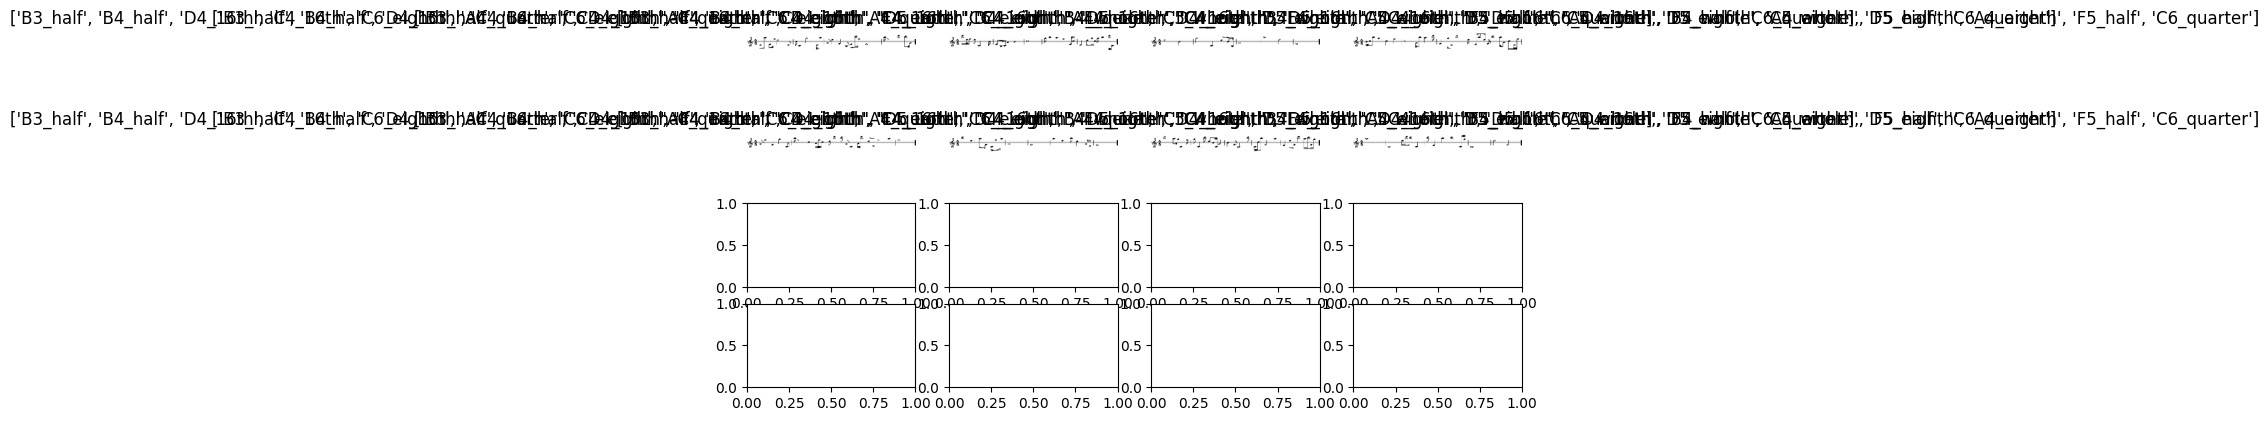

In [14]:

import keras
import tensorflow as tf
import numpy as np

from jiwer import wer

import matplotlib.pyplot as plt

from consonance.ml_logic.omr import build_model, ctc_decode, decode_batch_predictions, decode_labels, int_to_label, train_dataset, validation_dataset

In [15]:
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 350, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 350, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 175, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 175, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 87, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 87, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 87, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 87, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 87, 256)   │    197,632 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 87, 128)   │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 87, 87)    │     11,223 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 87, 87)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 441,239 (1.68 MB)

 Trainable params: 441,239 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from keras.callbacks import ModelCheckpoint


# Resume training, set up checkpoints
checkpoint_callback = ModelCheckpoint(
    '../data/model_checkpoints/modelv2_checkpoint.keras',   # Filepath to save the model
    monitor='val_loss',      # Monitor validation loss
    save_best_only=False,    # Save the model after every epoch
    save_weights_only=False, # Save the entire model, not just the weights
    verbose=1                # Print a message when saving the model
)

# model = keras.models.load_model('../data/model_checkpoints/model_checkpoint.keras')
# Train the model with checkpointing

early_stopping_patience = 20
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

additional_epochs = 1000

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=additional_epochs,
    callbacks=[early_stopping, checkpoint_callback],
)


Epoch 1/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 2091.3057
Epoch 1: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 136s 236ms/step - loss: 2090.9128 - val_loss: 1787.6399
Epoch 2/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 1729.7092
Epoch 2: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 148s 262ms/step - loss: 1729.6788 - val_loss: 1661.9366
Epoch 3/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 1640.0883
Epoch 3: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 146s 260ms/step - loss: 1640.0795 - val_loss: 1621.6899
Epoch 4/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 1608.9039
Epoch 4: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 145s 257ms/step - loss: 1608.8992 - val_loss: 1602.6912
Epoch 5/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - lo

KeyboardInterrupt: 

In [26]:
history.history

{'loss': [366.2253723144531,
  410.1946716308594,
  372.248779296875,
  367.34625244140625,
  379.64337158203125,
  360.83502197265625,
  370.2096862792969,
  381.3440856933594,
  377.19970703125,
  397.10894775390625,
  368.7077941894531,
  364.7494201660156,
  357.0810241699219,
  354.9805908203125,
  362.2419128417969,
  360.5658264160156,
  361.9710998535156,
  369.3399353027344,
  368.6838684082031,
  353.5267639160156,
  345.70635986328125,
  367.4122009277344,
  377.8725891113281,
  344.4266052246094,
  364.7612609863281,
  354.0828552246094,
  341.2023620605469,
  363.2464599609375,
  357.7773132324219,
  347.4781799316406,
  371.6073303222656,
  349.4715270996094,
  347.6629333496094,
  343.6841735839844,
  344.1330871582031,
  363.1991271972656,
  407.72406005859375,
  378.1257629394531,
  338.2703552246094,
  342.3031005859375,
  346.77154541015625,
  346.22637939453125,
  338.6761779785156,
  343.5682373046875,
  345.540771484375,
  355.5816955566406,
  382.241455078125,
  

In [23]:
# Combine previous history with new history
if previous_history:
    for key in history.history.keys():
        history.history[key] = previous_history[key] + history.history[key]


# Save the updated history
history_file = '../data/model_checkpoints/history.json'
save_history(history, history_file)

NameError: name 'history' is not defined

In [24]:
import os
import json
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping

# Function to save the training history
def save_history(history, filepath):
    with open(filepath, 'w') as f:
        json.dump(history.history, f)

# Function to load the training history
def load_history(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return json.load(f)
    else:
        return None

# Load previous history if it exists
history_file = '../data/model_checkpoints/history.json'
previous_history = load_history(history_file)

# Resume training, set up checkpoints
checkpoint_callback = ModelCheckpoint(
    '../data/model_checkpoints/modelv2_checkpoint.keras',
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

early_stopping_patience = 20
early_stopping = EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

model = keras.models.load_model('../data/model_checkpoints/modelv2_checkpoint.keras')

additional_epochs = 1000 - 165

# Train the model with checkpointing
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=additional_epochs,
    callbacks=[early_stopping, checkpoint_callback],
)

# Combine previous history with new history
if previous_history:
    for key in history.history.keys():
        history.history[key] = previous_history[key] + history.history[key]


# Save the updated history
history_file = '../data/model_checkpoints/history.json'
save_history(history, history_file)

Epoch 1/835
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 353.7254
Epoch 1: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 142s 249ms/step - loss: 353.7476 - val_loss: 349.1951
Epoch 2/835
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 399.7161
Epoch 2: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 149s 264ms/step - loss: 399.7347 - val_loss: 343.2327
Epoch 3/835
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 377.6221
Epoch 3: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 145s 257ms/step - loss: 377.6126 - val_loss: 300.0977
Epoch 4/835
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 360.0289
Epoch 4: saving model to ../data/model_checkpoints/modelv2_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 149s 265ms/step - loss: 360.0419 - val_loss: 423.3849
Epoch 5/835
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - loss: 397.7260
Epoc

In [27]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


2024-08-29 17:40:02.596330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


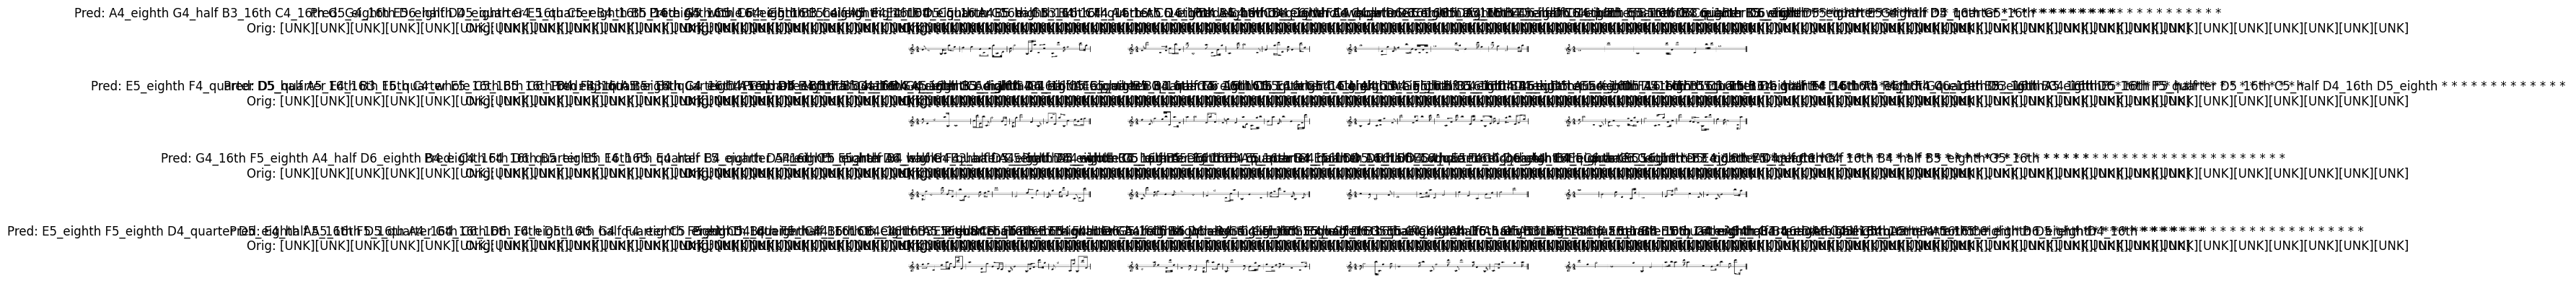

In [28]:
# Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        decoded_label = decode_labels([label.numpy()])[0]
        orig_text = ''.join([int_to_label.get(lbl, '[UNK]') for lbl in decoded_label])
        orig_texts.append(orig_text)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(min(len(pred_texts), 16)):  # Limit to 16 images for display
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Pred: {pred_texts[i]} \nOrig: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


In [29]:
combined_dict = {
    'B3_whole': 0, 'C4_whole': 1, 'D4_whole': 2, 'E4_whole': 3, 'F4_whole': 4, 'G4_whole': 5, 'A4_whole': 6, 'B4_whole': 7, 'C5_whole': 8,
    'D5_whole': 9, 'E5_whole': 10, 'F5_whole': 11, 'G5_whole': 12, 'A5_whole': 13, 'B5_whole': 14, 'C6_whole': 15, 'D6_whole': 16,

    'B3_half': 17, 'C4_half': 18, 'D4_half': 19, 'E4_half':20, 'F4_half': 21, 'G4_half': 22, 'A4_half': 23, 'B4_half': 24, 'C5_half': 25,
    'D5_half': 26, 'E5_half': 27, 'F5_half': 28, 'G5_half': 29, 'A5_half': 30, 'B5_half': 31, 'C6_half': 32, 'D6_half': 33,

    'B3_quarter': 34, 'C4_quarter': 35, 'D4_quarter': 36, 'E4_quarter': 37, 'F4_quarter': 38, 'G4_quarter': 39, 'A4_quarter': 40, 'B4_quarter': 41, 'C5_quarter': 42,
    'D5_quarter': 43, 'E5_quarter': 44, 'F5_quarter': 45, 'G5_quarter': 46, 'A5_quarter': 47, 'B5_quarter': 48, 'C6_quarter': 49, 'D6_quarter': 50,

    'B3_eighth': 51, 'C4_eighth': 52, 'D4_eighth': 53, 'E4_eighth': 54, 'F4_eighth': 55, 'G4_eighth': 56, 'A4_eighth': 57, 'B4_eighth': 58, 'C5_eighth': 59,
    'D5_eighth': 60, 'E5_eighth': 61, 'F5_eighth': 62, 'G5_eighth': 63, 'A5_eighth': 64, 'B5_eighth': 65, 'C6_eighth': 66, 'D6_eighth': 67,

    'B3_16th': 68, 'C4_16th': 69, 'D4_16th': 70, 'E4_16th': 71, 'F4_16th': 72, 'G4_16th': 73, 'A4_16th': 74, 'B4_16th': 75, 'C5_16th': 76,
    'D5_16th': 77, 'E5_16th': 78, 'F5_16th': 79, 'G5_16th': 80, 'A5_16th': 81, 'B5_16th': 82, 'C6_16th': 83, 'D6_16th': 84
}

In [32]:
import re

# Function to split combined labels like "F4_halfG4_eighth" into "F4_half G4_eighth"
def split_labels(label):
    return ' '.join(re.findall(r'[A-G][b#]?\d+_\w+', label))

# Apply this function to both targets and predictions for readability
split_targets = [split_labels(label) for label in targets]
split_predictions = [split_labels(pred) for pred in predictions]


In [37]:
# Convert numeric sequences back to their corresponding characters
def num_to_char(label):
    return ''.join([int_to_label.get(int(lbl), '[UNK]') for lbl in label])

predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch['image'], batch['label']
    batch_predictions = prediction_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

    for label in y:
        # Split the label into individual components first
        label_components = [int_to_label.get(int(lbl), '[UNK]') for lbl in label if int_to_label.get(int(lbl), '[UNK]') != '[UNK]']
        # Join them with a space to match the format of predictions
        label_string = ' '.join(label_components)
        targets.append(label_string)

# Function to split combined labels like "F4_halfG4_eighth" into "F4_half G4_eighth"
def split_labels(label):
    return ' '.join(re.findall(r'[A-G][b#]?\d+_\w+', label))

# Apply this function to both targets and predictions for readability
split_targets = [split_labels(label) for label in targets]
split_predictions = [split_labels(pred) for pred in predictions]

# Calculate Word Error Rate (WER)
wer_score = wer(split_targets, split_predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

# Display some random samples of predictions and targets
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {split_targets[i]}")
    print(f"Prediction: {split_predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━

2024-08-29 17:45:42.954565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
def character_level_accuracy(targets, predictions):
    total_chars = sum([len(target) for target in targets])
    correct_chars = sum([sum([1 for t, p in zip(target, pred) if t == p])
                         for target, pred in zip(targets, predictions)])
    return correct_chars / total_chars

char_accuracy = character_level_accuracy(targets, predictions)
print(f"Character-Level Accuracy: {char_accuracy:.4f}")


Character-Level Accuracy: 0.8423


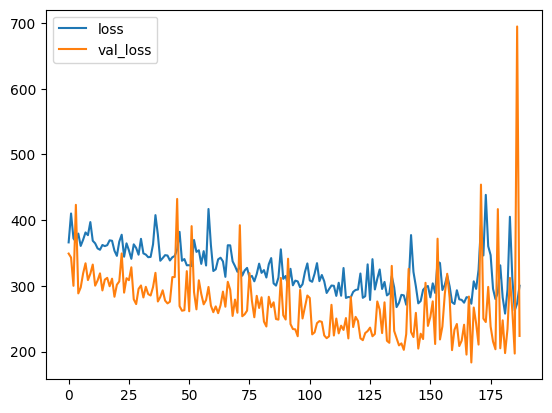

In [39]:
l = history.history
l, vl = l['loss'], l['val_loss']
plt.plot(l, label='loss')
plt.plot(vl, label='val_loss')
plt.legend()

In [49]:
model.save("../data/training_dual_model_1k.keras")
prediction_model.save("../data/predict_dual_1k.keras")

In [40]:
# Resume training, set up checkpoints

from keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    '../data/model_checkpoints/model_checkpoint.keras',   # Filepath to save the model
    monitor='val_loss',      # Monitor validation loss
    save_best_only=False,    # Save the model after every epoch
    save_weights_only=False, # Save the entire model, not just the weights
    verbose=1                # Print a message when saving the model
)

model = keras.models.load_model('../data/training_dual_model1.keras')
# Train the model with checkpointing

additional_epochs = 900

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=additional_epochs,
    callbacks=[early_stopping, checkpoint_callback],
)


Epoch 1/900


2024-08-29 17:46:19.587174: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at ctc_loss_op.cc:216 : INVALID_ARGUMENT: Saw a non-null label (index >= num_classes - 1) following a null label, batch: 7 num_classes: 86 labels: 13,17,78,84,66,35,66,37,48,49,69,80,85,27,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 labels seen so far: 13,17,78,84,66,35,66,37,48,49,69,80
2024-08-29 17:46:19.587197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Saw a non-null label (index >= num_classes - 1) following a null label, batch: 7 num_classes: 86 labels: 13,17,78,84,66,35,66,37,48,49,69,80,85,27,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 labels seen so far: 13,17,78,84,66,35,66,37,48,49,69,80
	 [[{{function_node __inference_one_step_on_data_2963250}}{{node ocr_model_v1_1/ctc_loss_1/CTCLoss}}]]


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/framework/errors_impl.py(284): __init__
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/eager/context.py(1500): call_function
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(919): _call
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py(318): fit
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py(117): error_handler
  /var/folders/bh/93g2q2fx3654lfb40kf_tyr40000gn/T/ipykernel_81858/1493383609.py(18): <module>
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3577): run_code
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3517): run_ast_nodes
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3334): run_cell_async
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3130): _run_cell
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3075): run_cell
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/ipkernel.py(449): do_execute
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/kernelbase.py(778): execute_request
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/ipkernel.py(362): execute_request
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/kernelbase.py(534): process_one
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /Users/ninjamac/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py(80): _run
  /Users/ninjamac/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py(1896): _run_once
  /Users/ninjamac/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py(600): run_forever
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/tornado/platform/asyncio.py(205): start
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel/kernelapp.py(739): start
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/traitlets/config/application.py(1075): launch_instance
  /Users/ninjamac/.pyenv/versions/3.10.6/envs/Consonance/lib/python3.10/site-packages/ipykernel_launcher.py(18): <module>
  /Users/ninjamac/.pyenv/versions/3.10.6/lib/python3.10/runpy.py(86): _run_code
  /Users/ninjamac/.pyenv/versions/3.10.6/lib/python3.10/runpy.py(196): _run_module_as_main


In [41]:
# Resume training, set up checkpoints
checkpoint_callback = ModelCheckpoint(
    '../data/model_checkpoints/model_checkpoint.keras',   # Filepath to save the model
    monitor='val_loss',      # Monitor validation loss
    save_best_only=False,    # Save the model after every epoch
    save_weights_only=False, # Save the entire model, not just the weights
    verbose=1                # Print a message when saving the model
)

model = keras.models.load_model('../data/model_checkpoints/model_checkpoint.keras')
# Train the model with checkpointing

early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

additional_epochs = 900

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=additional_epochs,
    callbacks=[early_stopping, checkpoint_callback],
)


Epoch 1/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 588.5265
Epoch 1: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 143s 251ms/step - loss: 588.5435 - val_loss: 478.0826
Epoch 2/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 552.9307
Epoch 2: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 145s 258ms/step - loss: 552.9053 - val_loss: 417.2036
Epoch 3/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 533.0451
Epoch 3: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 145s 257ms/step - loss: 533.0900 - val_loss: 496.5374
Epoch 4/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 596.0151
Epoch 4: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 150s 266ms/step - loss: 595.9795 - val_loss: 443.9289
Epoch 5/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 571.7637
Epoch 5: sav

In [43]:
prediction_model.save("../data/predict_modelv2.keras")

In [42]:
for i in np.random.randint(0, len(targets), 5):
    print(f"Target    : {targets[i]}")

Target    : F4_16th B5_16th B4_eighth F5_eighth C6_quarter D4_16th B3_quarter C6_16th D6_whole D5_eighth G4_half C5_eighth G5_eighth A4_16th D5_16th D6_whole D4_eighth B4_quarter G5_eighth A4_eighth D4_16th D5_quarter C6_16th * * * * * * * * * * * * * * * * * * *
Target    : A4_half D5_half B5_whole C5_16th D5_eighth B3_16th C4_eighth A4_half B4_eighth D6_quarter D4_quarter C4_half D5_eighth B5_16th C6_quarter E5_half D4_16th * * * * * * * * * * * * * * * * * * * * * * * * *
Target    : E5_quarter B5_16th F5_quarter G4_16th B4_eighth E5_eighth D4_eighth A4_16th F5_quarter G4_eighth B4_eighth B3_eighth A4_16th G4_eighth B5_16th G4_16th A4_half A5_eighth D6_eighth E5_eighth E4_eighth A5_16th E4_eighth A4_16th D5_quarter F5_16th C6_eighth B4_16th D4_quarter F5_16th G5_half B5_quarter G4_16th F4_eighth * * * * * * * *
Target    : E5_16th B5_16th E4_half E5_eighth A4_quarter E4_eighth B5_16th G4_half C4_16th D4_eighth D6_eighth C6_whole A4_16th C4_16th D5_half B4_16th C4_eighth D5_eighth G5